Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from spacy import load
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Loading Data

In [2]:
path = "C:/Users/user/Downloads/DiceyTechHack"
data  = pd.read_csv(path +"/TwitterData.csv",encoding="utf-8")

Data Familirization

In [3]:
data.head(2)

,Date,Content Type,Sent by,Post,Impressions,Potential Reach,Engagement Rate (per Impression),Engagements,Likes,Comments,...,Post Media Clicks,Post Hashtag Clicks,Post Detail Expand Clicks,Profile Clicks,Other Engagements,Follows from Post,Unfollows from Post,Video Views,Media Views,Tags
0,7/13/2023 10:57,Photo,Sophia Amuka,Your money should not be a gamble. Before you ...,445,345718,0.04,16,4,2,...,1,0,7,1,0,0,0,0,1,CIB Posts
1,7/12/2023 20:03,Text,Blessing Ubah,"What skill (s) do you have, that no one ever t...",2961,347102,0.02,52,11,20,...,0,1,12,5,0,0,0,0,0,Other


Data Preprocessing

In [4]:
data["Date"] = pd.to_datetime(data["Date"])
data["PostHour"] = data["Date"].dt.hour
data["PostMonth"] = data["Date"].dt.month_name()
data["PostYear"] = data["Date"].dt.year

In [5]:
data.columns

Index(['Date', 'Content Type', 'Sent by', 'Post', 'Impressions',
       'Potential Reach', 'Engagement Rate (per Impression)', 'Engagements',
       'Likes', 'Comments', 'Shares', 'Click-Through Rate', 'Post Link Clicks',
       'Other Post Clicks', 'Post Clicks (All)', 'Post Media Clicks',
       'Post Hashtag Clicks', 'Post Detail Expand Clicks', 'Profile Clicks',
       'Other Engagements', 'Follows from Post', 'Unfollows from Post',
       'Video Views', 'Media Views', 'Tags', 'PostHour', 'PostMonth',
       'PostYear'],
      dtype='object')

Sentiment, Topic and Entity Recognition

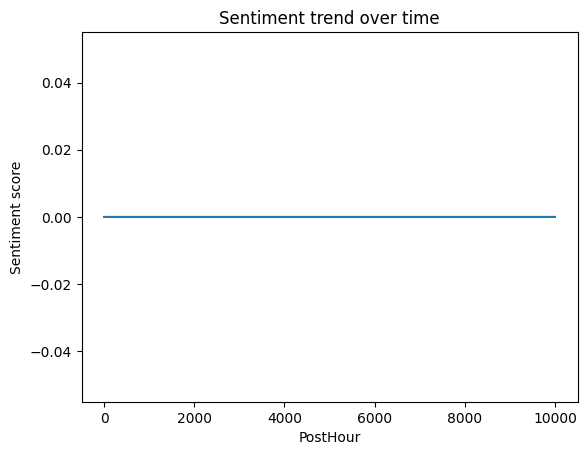

In [8]:
import re
df = pd.read_csv(path + '/InstagramData.csv', usecols=["Post"])

# Convert the 'Post' column to strings
df['Post'] = df['Post'].astype(str)

# Perform sentiment analysis
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []
for post in df['Post']:
    sentiment_score = sentiment_analyzer.polarity_scores(post)['compound']
    sentiment_scores.append(int(sentiment_score))

df['sentiment_score'] = sentiment_scores

# Perform topic modeling
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Post'])

lda = LatentDirichletAllocation(n_components=10)
lda_model = lda.fit(X)

topics = lda_model.components_
topic_names = ['Topic {}'.format(i) for i in range(len(topics))]

df['topic'] = lda_model.transform(X).argmax(axis=1)

# Perform entity recognition
nlp = load('en_core_web_sm')
entities = []

for post in df['Post']:
    doc = nlp(post)
    entities.append([entity.text for entity in doc.ents])

df['entities'] = entities

# Perform keyword analysis
keywords = []
for post in df['Post']:
    words = re.split(r'\W', post.lower())
    keywords.append(Counter(words).most_common(10))

df['keywords'] = keywords

# Identify trends
plt.plot(df['sentiment_score'])
plt.xlabel('PostHour')
plt.ylabel('Sentiment score')
plt.title('Sentiment trend over time')
plt.show()

In [9]:
data["Topic"] = df["topic"]
data["Entities"] = df["entities"]
data["Keywords"] = df["keywords"]

Text Analysis - Word Cloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


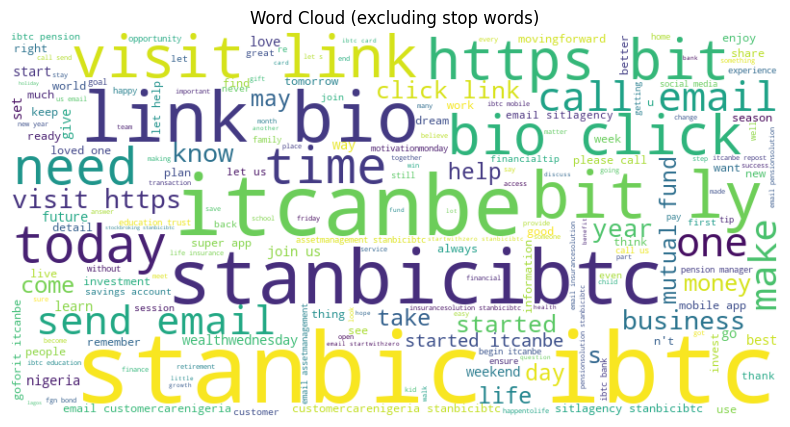

In [10]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Combine all the text from the 'post' column into a single string
all_text = ' '.join(df['Post'])

# Tokenize the text
tokens = word_tokenize(all_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

# Join the filtered tokens back into a string
filtered_text = ' '.join(filtered_tokens)

# Create a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (excluding stop words)')
plt.show()

In [11]:
data.columns

Index(['Date', 'Content Type', 'Sent by', 'Post', 'Impressions',
       'Potential Reach', 'Engagement Rate (per Impression)', 'Engagements',
       'Likes', 'Comments', 'Shares', 'Click-Through Rate', 'Post Link Clicks',
       'Other Post Clicks', 'Post Clicks (All)', 'Post Media Clicks',
       'Post Hashtag Clicks', 'Post Detail Expand Clicks', 'Profile Clicks',
       'Other Engagements', 'Follows from Post', 'Unfollows from Post',
       'Video Views', 'Media Views', 'Tags', 'PostHour', 'PostMonth',
       'PostYear', 'Topic', 'Entities', 'Keywords'],
      dtype='object')

Content Analysis

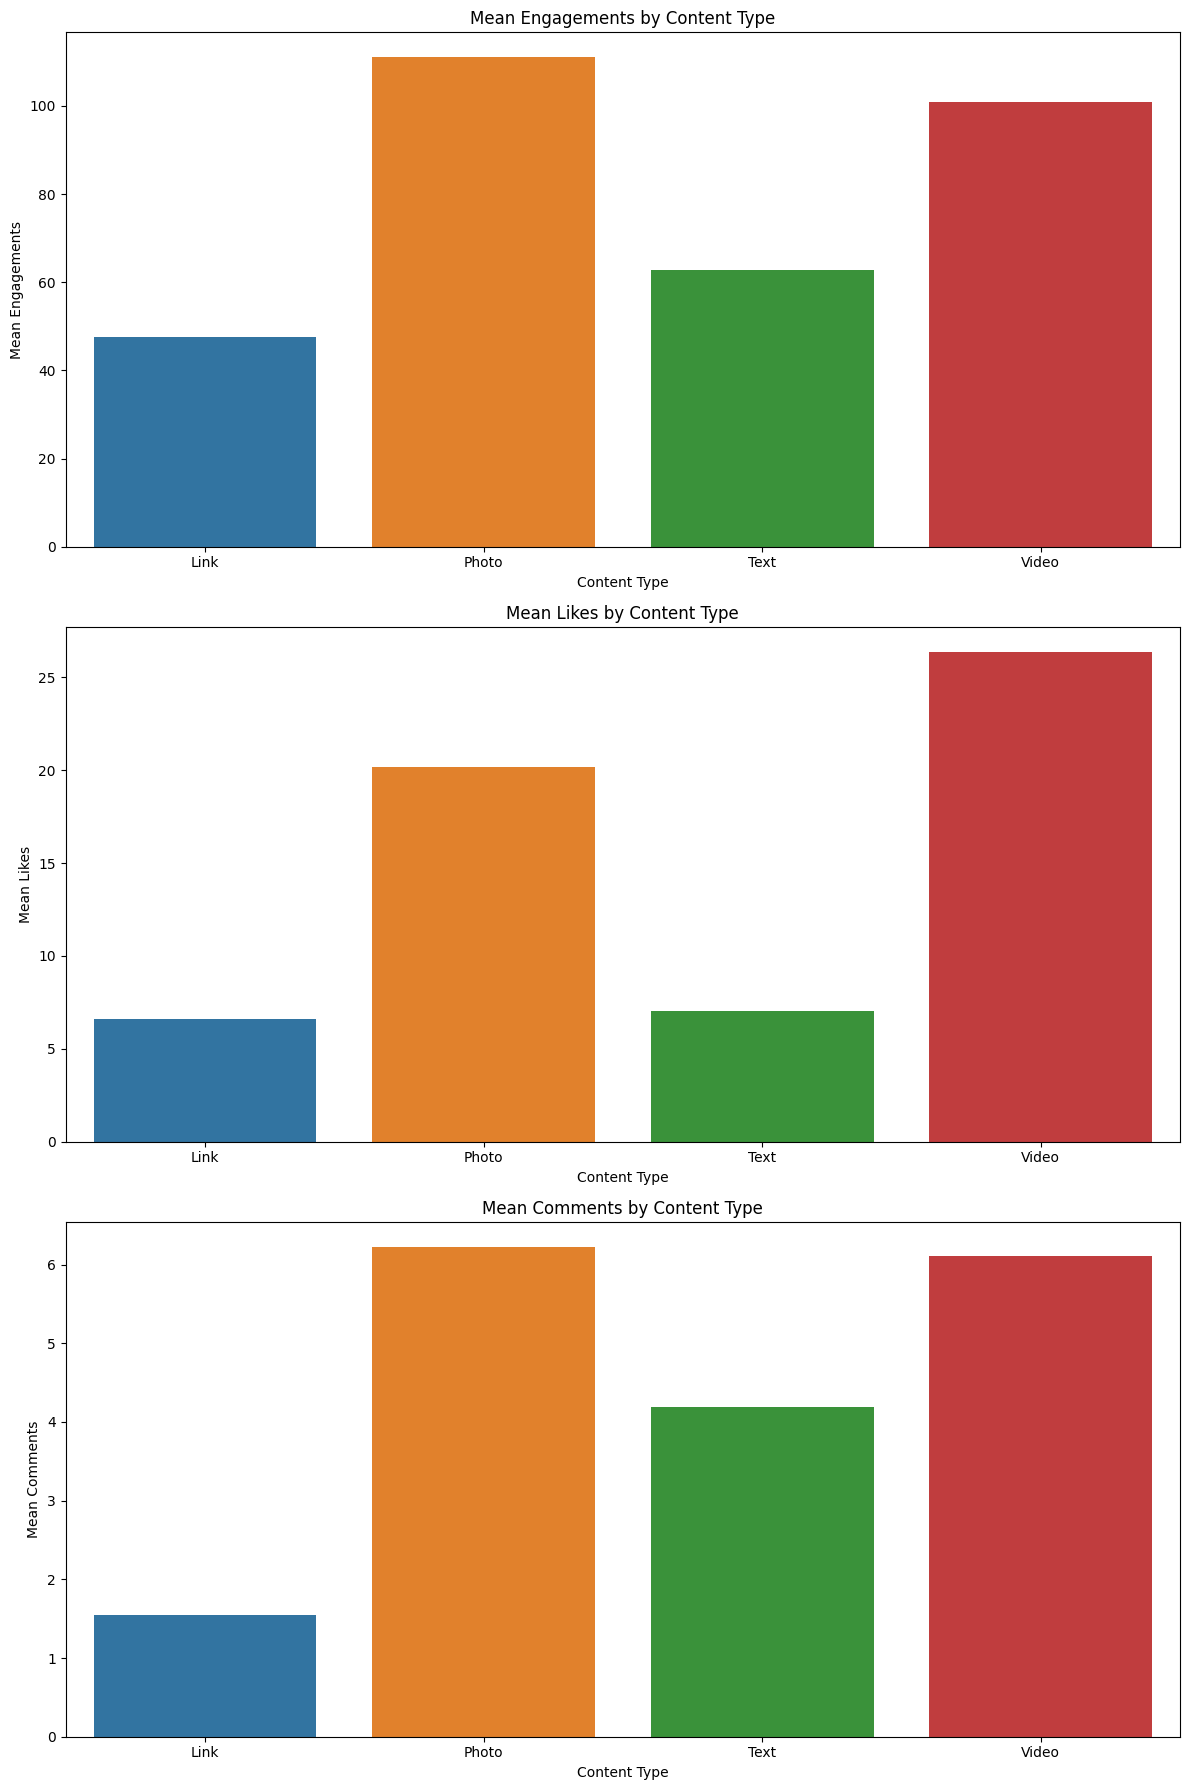

In [6]:
engagement_by_content_type = data.groupby('Content Type')[['Engagements', 'Likes', 'Comments']].mean().reset_index()

engagement_by_content_type = pd.DataFrame(engagement_by_content_type)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

sns.barplot(data=engagement_by_content_type, x='Content Type', y='Engagements', ax=axes[0])
sns.barplot(data=engagement_by_content_type, x='Content Type', y='Likes', ax=axes[1])
sns.barplot(data=engagement_by_content_type, x='Content Type', y='Comments', ax=axes[2])

axes[0].set_xlabel('Content Type')
axes[0].set_ylabel('Mean Engagements')
axes[0].set_title('Mean Engagements by Content Type')

axes[1].set_xlabel('Content Type')
axes[1].set_ylabel('Mean Likes')
axes[1].set_title('Mean Likes by Content Type')

axes[2].set_xlabel('Content Type')
axes[2].set_ylabel('Mean Comments')
axes[2].set_title('Mean Comments by Content Type')

plt.tight_layout()
plt.show()

Sent By Analysis

Text(0.5, 1.0, 'Engagements by Sent by')

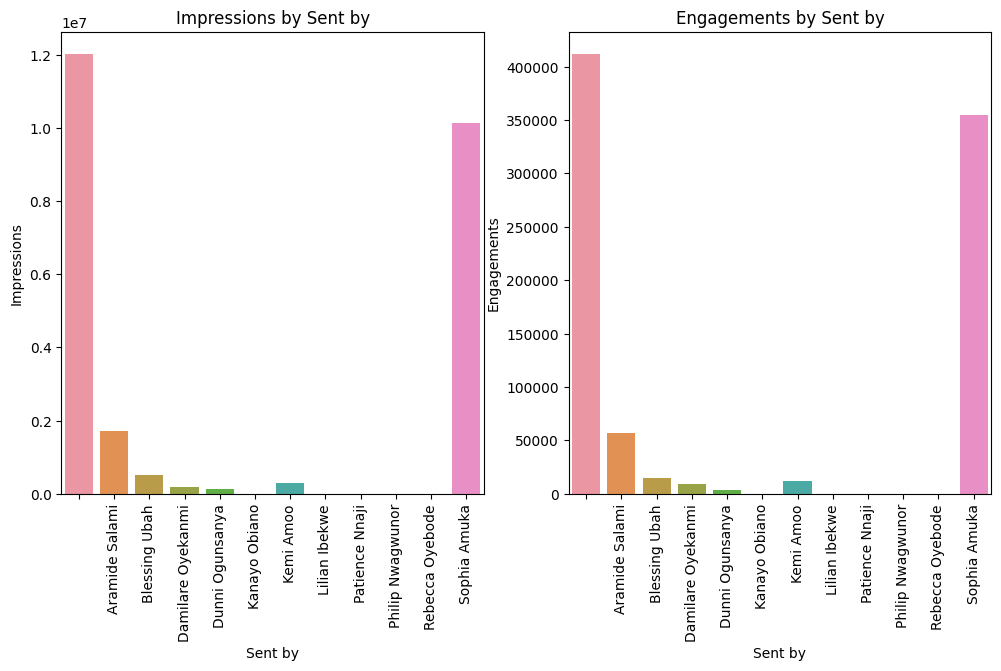

In [ ]:
sent_by_data = data.groupby('Sent by').sum().reset_index()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.barplot(x = "Sent by", y = "Impressions",data = sent_by_data)
plt.xticks(rotation=90)
plt.title("Impressions by Sent by")

plt.subplot(1,2,2)
sns.barplot(x = "Sent by", y = "Engagements",data = sent_by_data)
plt.xticks(rotation=90)
plt.title("Engagements by Sent by")

Engagement Rate Analysis

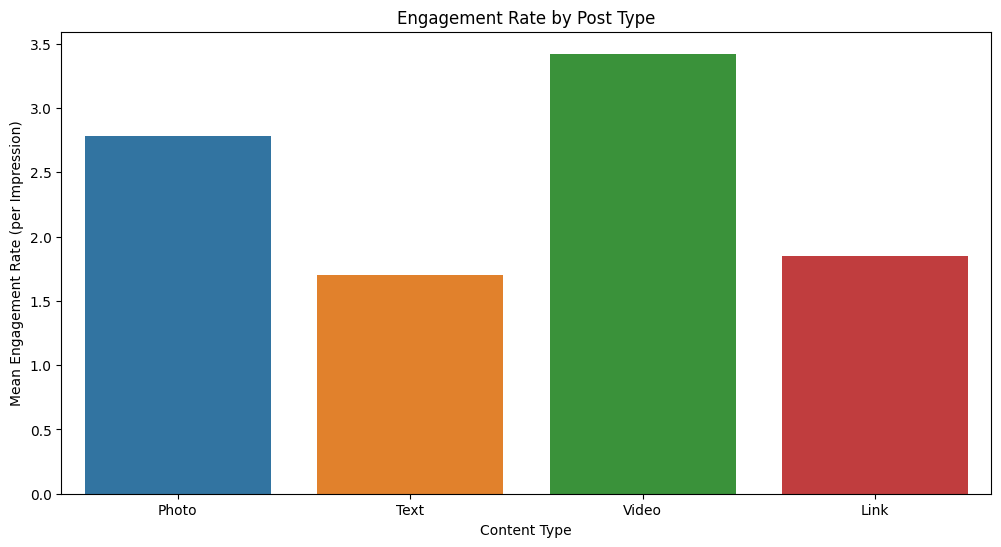

In [ ]:
#Engagement Rate Analysis
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Content Type', y='Engagement Rate (per Impression)', ci=None)
plt.xlabel('Content Type')
plt.ylabel('Mean Engagement Rate (per Impression)')
plt.title('Engagement Rate by Post Type')
plt.show()

Click-Through Rate Analysis

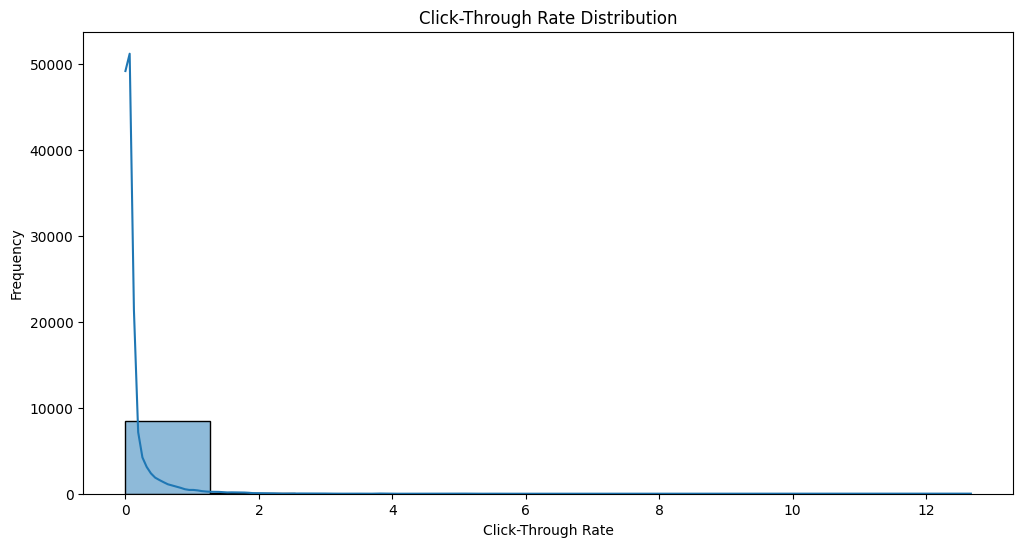

In [ ]:
# Click-Through Rate Analysis
plt.figure(figsize=(12, 6))
sns.histplot(data['Click-Through Rate'], bins=10, kde=True)
plt.xlabel('Click-Through Rate')
plt.ylabel('Frequency')
plt.title('Click-Through Rate Distribution')
plt.show()

Hourly Analysis

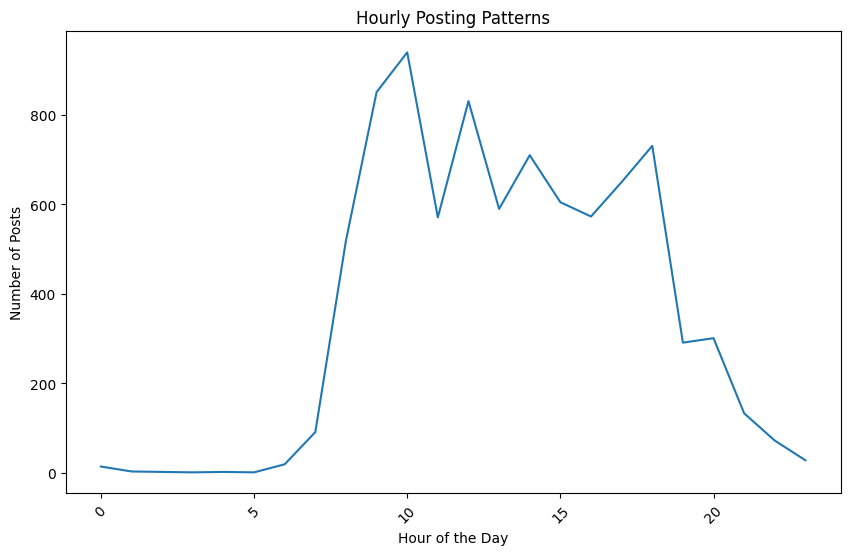

In [ ]:
hourly_posting = data['PostHour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_posting.index, y=hourly_posting.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Posts')
plt.title('Hourly Posting Patterns')
plt.xticks(rotation=45)
plt.show()

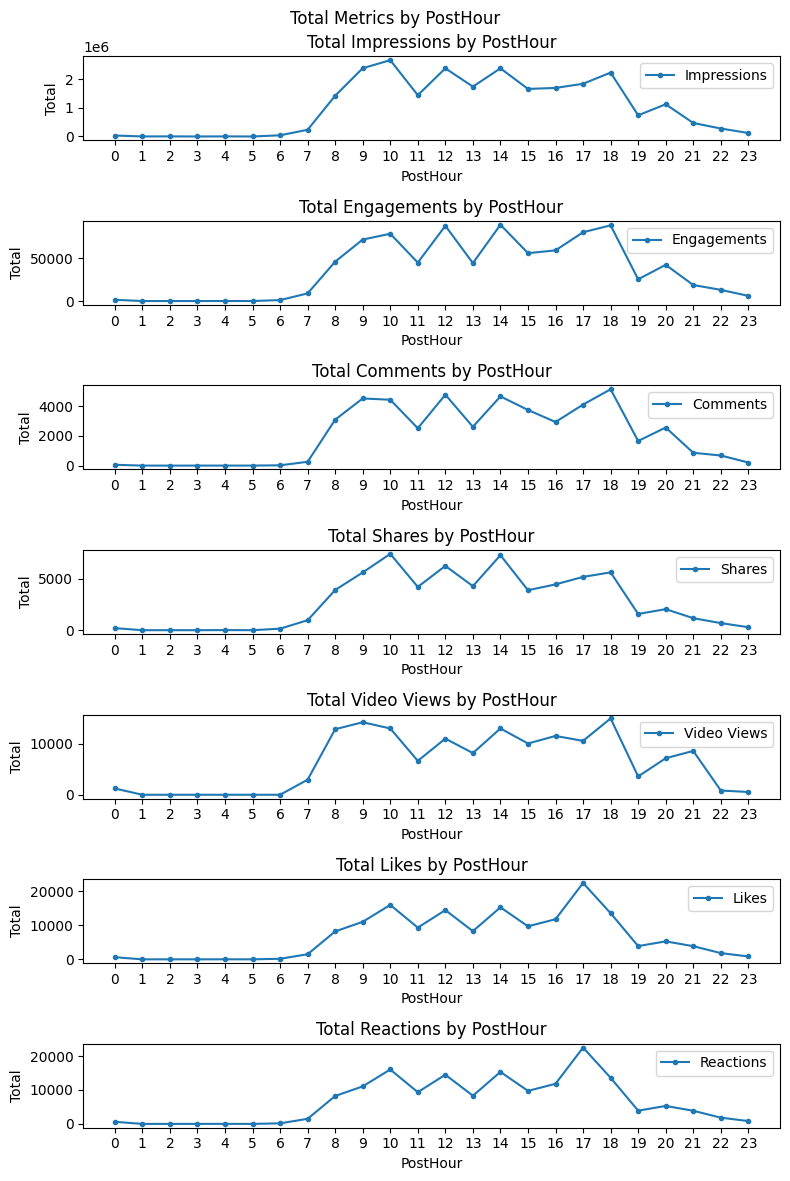

In [ ]:
grouped_data = data.groupby('PostHour')[['Impressions', 'Engagements','Comments','Shares','Video Views','Likes', 'Reactions']].sum()

hours = list(range(24))

sorted_data = grouped_data.sort_values(by='PostHour')

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 12))

plt.subplots_adjust(hspace=0.5)

for i, metric in enumerate(['Impressions', 'Engagements','Comments','Shares','Video Views','Likes', 'Reactions']):
    ax = axes[i]

    ax.plot(hours, sorted_data[metric], label=metric, marker='.')

    ax.set_title(f'Total {metric} by PostHour')
    ax.set_xlabel('PostHour')
    ax.set_ylabel('Total')

    ax.set_xticks(hours)
    ax.legend()

fig.suptitle('Total Metrics by PostHour')

plt.tight_layout()

plt.show()

Top 5 Performing Years

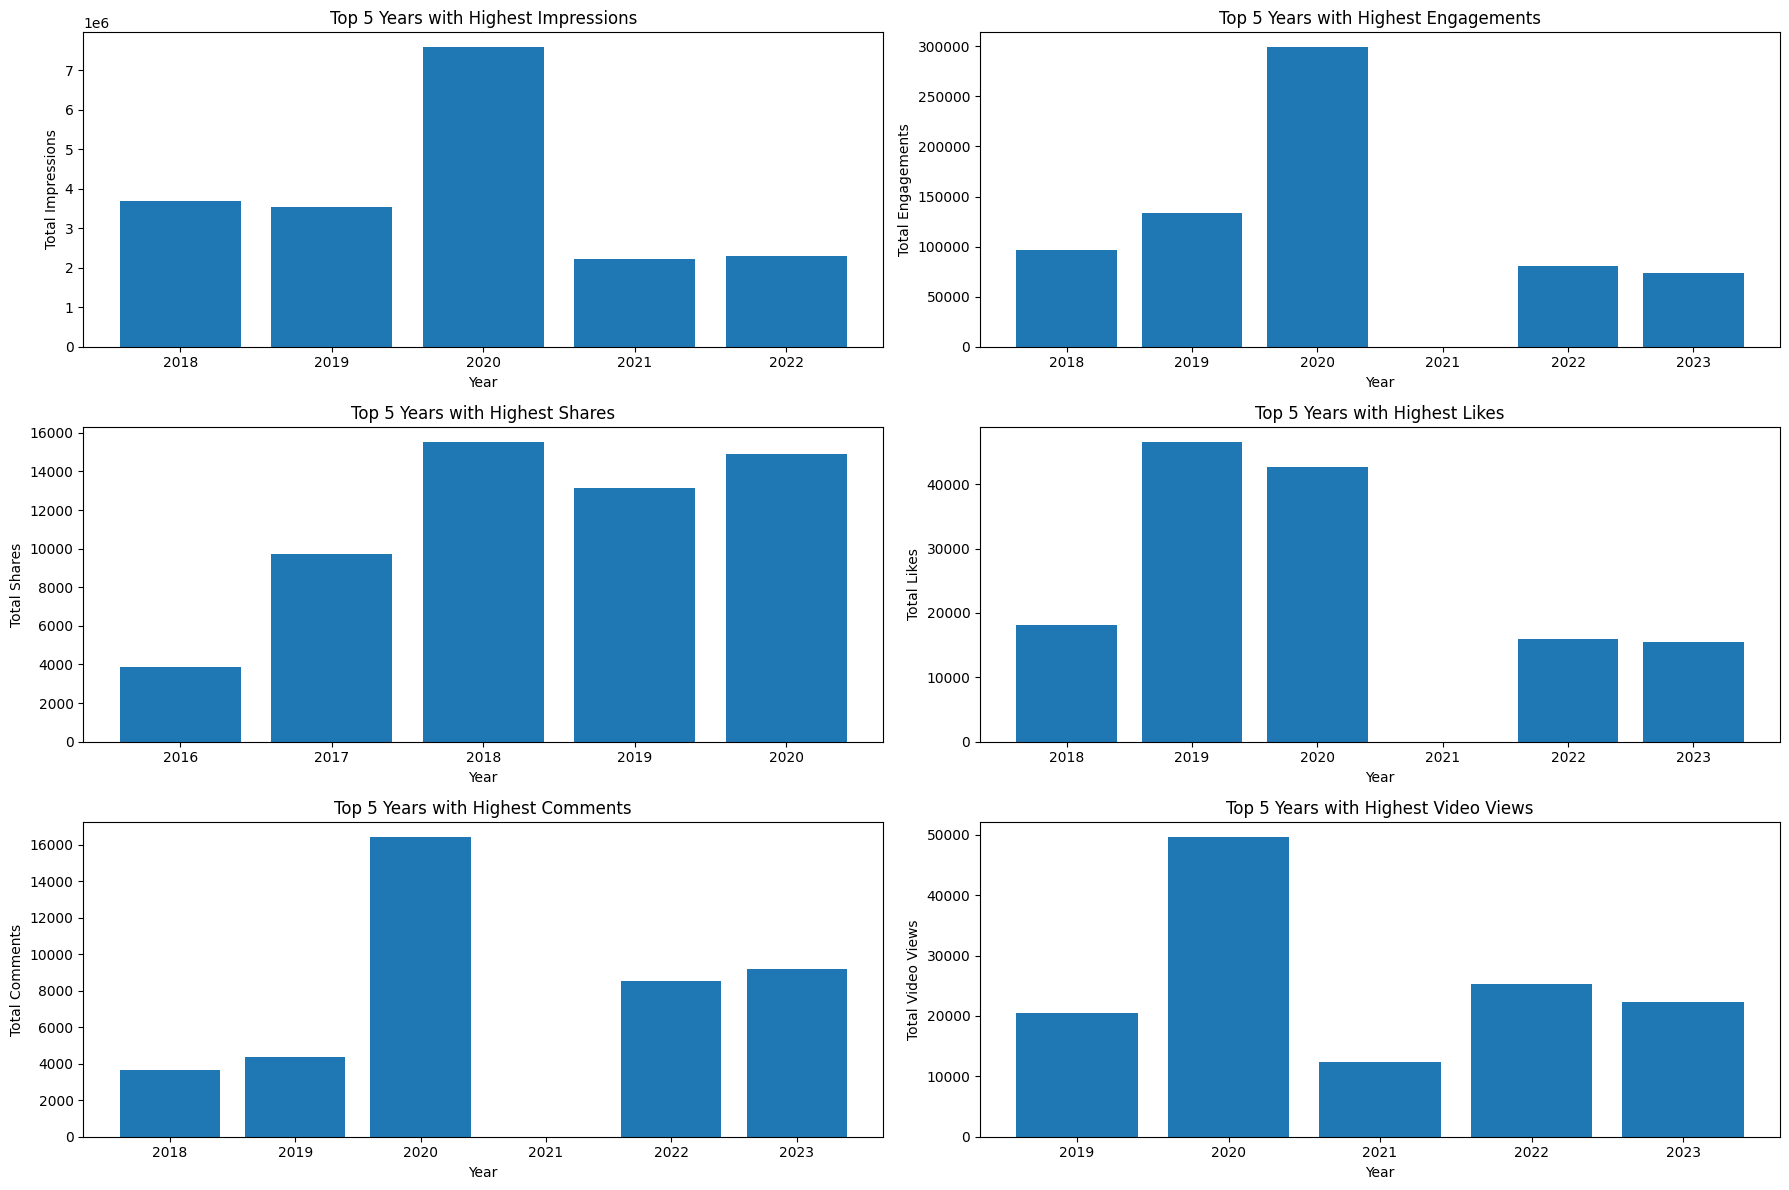

In [ ]:
yearly_data = data.groupby('PostYear')[['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']].sum()

sorted_yearly_data = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    sorted_yearly_data[metric] = yearly_data.sort_values(by=metric, ascending=False)

top_5_years = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    top_5_years[metric] = sorted_yearly_data[metric].head(5)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

for i, metric in enumerate(['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']):
    ax = axes[i // 2, i % 2]
    ax.bar(top_5_years[metric].index, top_5_years[metric][metric])
    ax.set_title(f'Top 5 Years with Highest {metric}')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Total {metric}')

plt.tight_layout()

plt.show()

Top 5 performing Months

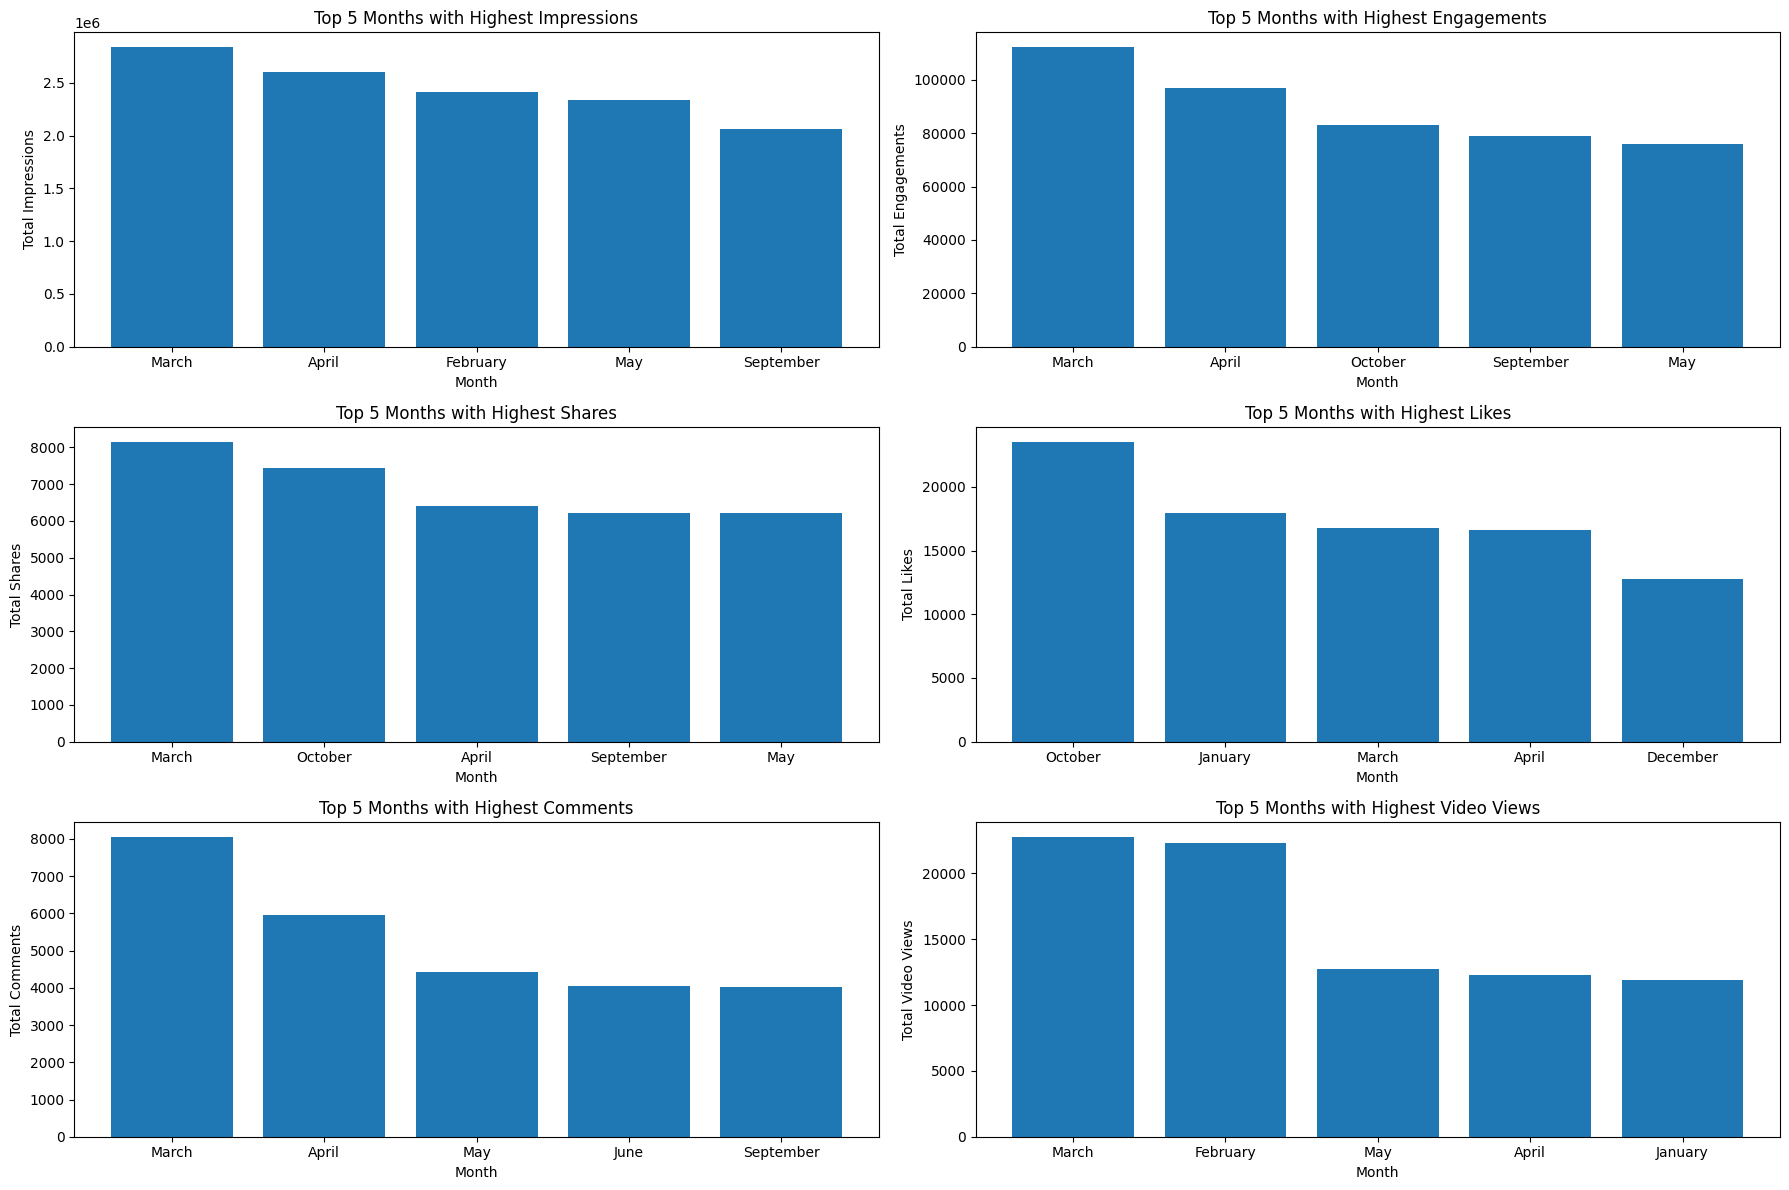

In [ ]:
monthly_data = data.groupby('PostMonth')[['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']].sum()

sorted_monthly_data = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    sorted_monthly_data[metric] = monthly_data.sort_values(by=metric, ascending=False)

top_5_months = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    top_5_months[metric] = sorted_monthly_data[metric].head(5)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

for i, metric in enumerate(['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']):
    ax = axes[i // 2, i % 2]
    ax.bar(top_5_months[metric].index, top_5_months[metric][metric])
    ax.set_title(f'Top 5 Months with Highest {metric}')
    ax.set_xlabel('Month')
    ax.set_ylabel(f'Total {metric}')

plt.tight_layout()

plt.show()

Post Duration Analysis

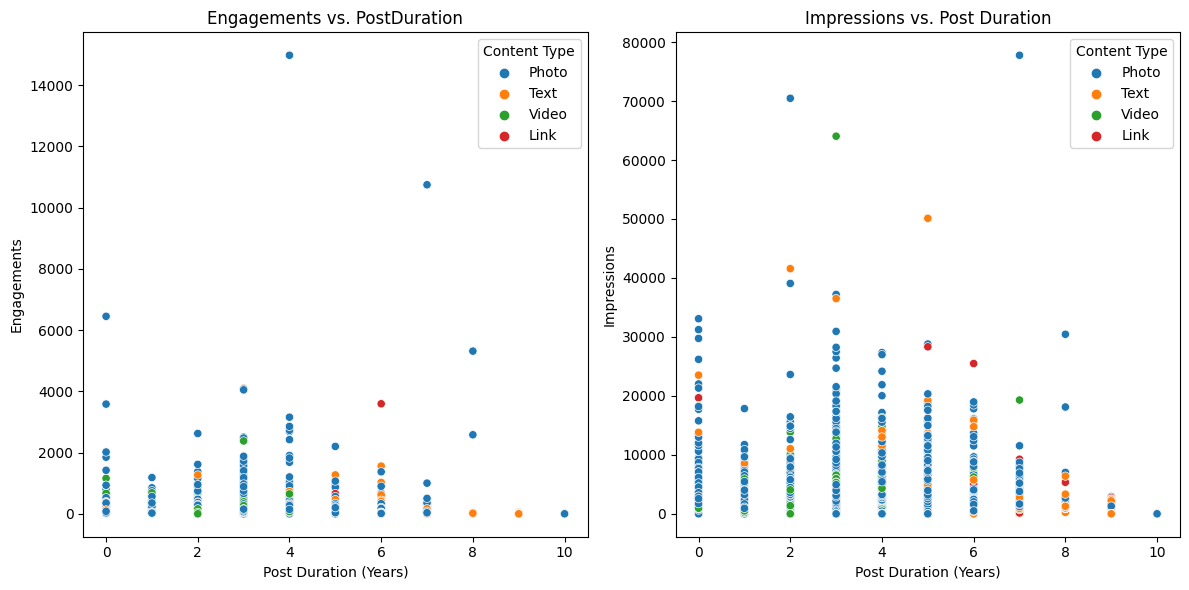

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1) 
sns.scatterplot(data=data, x='PostDuration', y='Engagements', hue='Content Type', ax=ax1)
ax1.set_xlabel('Post Duration (Years)')
ax1.set_ylabel('Engagements')
ax1.set_title('Engagements vs. PostDuration')

ax2 = plt.subplot(1, 2, 2) # Right subplot for Impressions
sns.scatterplot(data=data, x='PostDuration', y='Impressions', hue='Content Type', ax=ax2)
ax2.set_xlabel('Post Duration (Years)')
ax2.set_ylabel('Impressions')
ax2.set_title('Impressions vs. Post Duration')

plt.tight_layout()
plt.show()

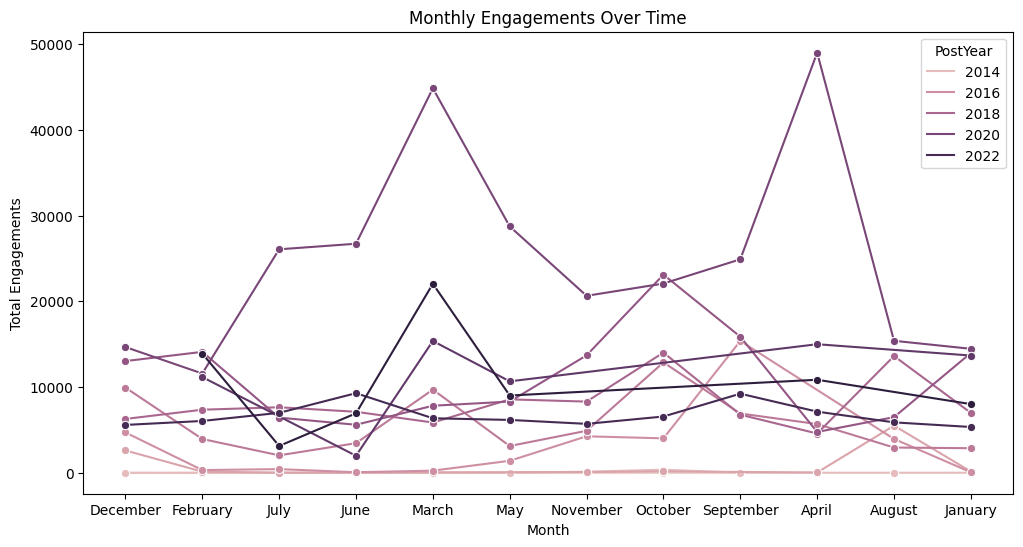

In [ ]:
monthly_engagement = data.groupby(['PostYear', 'PostMonth'])['Engagements'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_engagement, x='PostMonth', y='Engagements', hue='PostYear', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Engagements')
plt.title('Monthly Engagements Over Time')
plt.show()